## **Packages**

In [1]:
# packages
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from hdfs import InsecureClient
import datetime as dt
import pandas as pd

In [2]:
# python과 mysql 연결을 위한 필요모듈 패키지
# !pip install pymysql
import pymysql

/home/lab09/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


## **DM DB계정 생성**
[DM]
- User : bigDM@'%'
- PW : bigDM1234@
- DB : etlmysqlDM 

### 📍DB 계정 생성 (mysql)

In [6]:
# mysql에서 진행

## mysql 실행 (aws는 ubuntu 계정에서 실행)
# service mysql start (docker) / sudo service mysql start (aws)
# mysql -u root (docker) / sudo mysql -u root -p (aws)
# password : root (aws)

## user 생성
# mysql> create user bigDM@'%' identified by 'bigDM1234@';
# mysql> grant all privileges on *.* to bigDM@'%' with grant option;

## 사용할 database 생성
# mysql> create database if not exists etlmysqlDM;
# mysql> show databases;

## **DM/DW 연결 정보**

### 📍DM/DW 연결 정보 

In [3]:
conf_dw = {
      'url':'jdbc:mysql://35.77.255.41:3306/etlmysql?character_set_server=utf8mb4&serverTimezone=Asia/Seoul'
     ,'props':{
      'user':'bigMysql',
      'password':'bigMysql1234@'   
      }
}

conf_dm = {
      'url':'jdbc:mysql://35.77.255.41:3306/etlmysqlDM?character_set_server=utf8mb4&serverTimezone=Asia/Seoul'
     ,'props':{
      'user':'bigDM',
      'password':'bigDM1234@'   
      }
}

### 📍Table 저장/가져오기 관련 함수

In [4]:
# config : db 연결 정보
# spark.read.jdbc() : db에서 명시된 테이블을 반환받는 모듈

# Table 가져오기
def find_data(config, table_name) :
    return spark.read.jdbc(url= config['url'], table=table_name, properties=config['props'])

# Table 저장
def save_data(config, df, table_name) :
    return df.write.jdbc(url= config['url'], table=table_name, mode='append' , properties=config['props'])

## **DW Data 가져오기**

### **📍 관광지 정보 데이터**
- dw db (etlmysql)에 'OVERALL' 테이블

In [5]:
travel_data = find_data(conf_dw, 'OVERALL')

In [6]:
travel_data.columns

['index',
 '개요',
 '개장기간',
 '공연시간',
 '관광지 분류',
 '관람소요시간',
 '명칭',
 '분류',
 '상세정보',
 '쉬는날',
 '애완동물 동반 가능 여부',
 '우편번호',
 '유모차 대여 여부',
 '이용시간',
 '이용시기',
 '이용요금',
 '입장료',
 '전화번호',
 '주소',
 '주차시설',
 '주차요금',
 '지역',
 '체험안내',
 '행사시작일',
 '행사종료일']

### **📍 평점 데이터**
- dw db (etlmysql)에 'RATINGS' 테이블

In [6]:
tour_ratings = find_data(conf_dw, 'RATINGS')

In [8]:
tour_ratings.columns

['index', '명칭', '평점']

### **📍 관광지 키워드 데이터**
- dw db (etlmysql)에 'KEYWORDS' 테이블

In [7]:
tour_keywords = find_data(conf_dw, 'KEYWORDS')

In [9]:
tour_keywords.columns

['Top_Keyword_1',
 'Top_Keyword_2',
 'Top_Keyword_3',
 'Tourist_Spot_Name',
 'index']

### **📍 관광지 이미지 경로 데이터**
- dw db (etlmysql)에 'IMGPATH' 테이블

In [22]:
tour_imgpath = find_data(conf_dw, 'IMGPATH')

In [23]:
tour_imgpath.columns

['image_path', 'index', 'tour_name']

## **Table 구성**

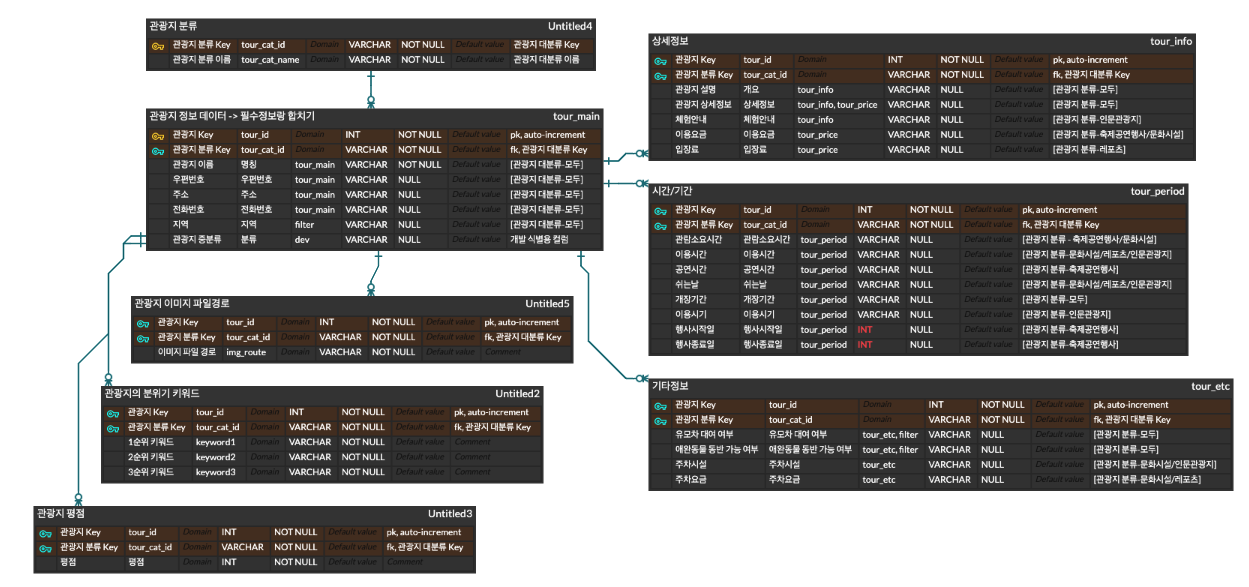

### 1️⃣ 관광지 분류 

✔️ Table 명 : tour_category

<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [pk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / *새로 생성,auto-increment
- [column] : tour_cat_name / VARCHAR / NOT NULL / 관광지 대분류 이름  / '관광지 분류'의 Unique 값

In [11]:
# tour_cat_name 
tour_category = travel_data.select(travel_data['관광지 분류'].alias('tour_cat_name')).distinct()

In [12]:
tour_category.show()

+-------------+
|tour_cat_name|
+-------------+
| 축제공연행사|
|   인문관광지|
|     문화시설|
|       레포츠|
+-------------+



In [13]:
# dm db 저장
save_data(conf_dm, tour_category, 'tour_category')

In [59]:
# tour_cat_id (mysql에서 진행)

## tour_cat_id 컬럼 생성
# mysql> ALTER TABLE tour_category ADD COLUMN tour_cat_id INT NOT NULL;

## pk 지정
# mysql> ALTER TABLE tour_category MODIFY tour_cat_id INT NOT NULL AUTO_INCREMENT PRIMARY KEY FIRST;

### 2️⃣ 관광지 정보 데이터

✔️ Table 명 : tour_main
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [pk] : tour_id / INT / NOT NULL / 관광지 Code / 'index' (auto_increment로 수정)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_category]의 'tour_cat_id' ('관광지 분류' 일치시키기)
- [column] : name / VARCHAR / NOT NULL / 관광지 이름 / '명칭'
- [column] : postal_code / VARCHAR / NULL / 우편번호 / '우편번호'
- [column] : address / VARCHAR / NULL / 주소 / '주소'
- [column] : contact / VARCHAR / NULL / 전화번호 / '전화번호'
- [column] : area / VARCHAR / NULL / 지역 / '지역'

In [14]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
tour_category = find_data(conf_dm, 'tour_category')

In [15]:
tour_category.show()

+-----------+-------------+
|tour_cat_id|tour_cat_name|
+-----------+-------------+
|          1| 축제공연행사|
|          2|   인문관광지|
|          3|     문화시설|
|          4|       레포츠|
+-----------+-------------+



In [16]:
# 필요 컬럼 불러오기
tmp = travel_data.select('index', '명칭', '우편번호', '주소', '전화번호', '지역', '관광지 분류')

In [17]:
tmp.show()

+-----+------------------------------+---------+----------------------------------+-------------+------+------------+
|index|                          명칭| 우편번호|                              주소|     전화번호|  지역| 관광지 분류|
+-----+------------------------------+---------+----------------------------------+-------------+------+------------+
|    1|                  (주)교보문고|   3154.0| 서울특별시 종로구 종로 1(종로1가)|         null|  서울|    문화시설|
|    2|          1.21 무장공비 침투로|486-890,1|   경기도 연천군 장남면 반정리 294|         null|경기도|  인문관광지|
|    3|         2024 코리아그랜드세일|   3162.0|  서울특별시 종로구 인사동5길 2...|070-7787-4242|  서울|축제공연행사|
|    4| 24시 마린낚시(전곡항 24 마...|  18554.0| 경기도 화성시 서신면 전곡항로 317|         null|경기도|      레포츠|
|    5|                      93뮤지엄|  10859.0|경기도 파주시 탄현면 헤이리마을...|         null|경기도|    문화시설|
|    6|                   CICA 미술관|  10049.0|  경기도 김포시 양촌읍 삼도로 1...|         null|경기도|    문화시설|
|    7|  C아트뮤지엄(숲속의 미술공원)|  12538.0|경기도 양평군 양동면 다락근이길...|         null|경기도|    문화시설|
|    8|                  

In [18]:
# tour_cat_id 
# [tour_category]의 'tour_cat_id' & '관광지 분류' 일치시키기

joined_df = tmp.join(tour_category, tmp['관광지 분류']==tour_category['tour_cat_name'], 'inner')

In [19]:
# 확인 
joined_df[joined_df['관광지 분류']=='축제공연행사'].select('명칭', '관광지 분류', 'tour_cat_name', 'tour_cat_id').show(2)
joined_df[joined_df['관광지 분류']=='레포츠'].select('명칭', '관광지 분류', 'tour_cat_name', 'tour_cat_id').show(2)
joined_df[joined_df['관광지 분류']=='인문관광지'].select('명칭', '관광지 분류', 'tour_cat_name', 'tour_cat_id').show(2)
joined_df[joined_df['관광지 분류']=='문화시설'].select('명칭', '관광지 분류', 'tour_cat_name', 'tour_cat_id').show(2)

+------------------------------+------------+-------------+-----------+
|                          명칭| 관광지 분류|tour_cat_name|tour_cat_id|
+------------------------------+------------+-------------+-----------+
|         2024 코리아그랜드세일|축제공연행사| 축제공연행사|          1|
|K-일러스트레이션페어 서울 2024|축제공연행사| 축제공연행사|          1|
+------------------------------+------------+-------------+-----------+
only showing top 2 rows

+-----------------------------+-----------+-------------+-----------+
|                         명칭|관광지 분류|tour_cat_name|tour_cat_id|
+-----------------------------+-----------+-------------+-----------+
|24시 마린낚시(전곡항 24 마...|     레포츠|       레포츠|          4|
|                 DMZ 마루캠핑|     레포츠|       레포츠|          4|
+-----------------------------+-----------+-------------+-----------+
only showing top 2 rows

+--------------------+-----------+-------------+-----------+
|                명칭|관광지 분류|tour_cat_name|tour_cat_id|
+--------------------+-----------+-------------+-----------+
|1.2

In [20]:
# 필요 컬럼 select 해서 tour_main 최종 구성
tour_main = joined_df.select(col('index').alias('tour_id'),
                             col('tour_cat_id'),
                             col('명칭').alias('name'),
                             col('우편번호').alias('postal_code'),
                             col('주소').alias('address'),
                             col('전화번호').alias('contact'),
                             col('지역').alias('area'))
tour_main.show()

+-------+-----------+--------------------------------+-----------+-----------------------------------+-------+------+
|tour_id|tour_cat_id|                            name|postal_code|                            address|contact|  area|
+-------+-----------+--------------------------------+-----------+-----------------------------------+-------+------+
|      4|          4|   24시 마린낚시(전곡항 24 마...|    18554.0|  경기도 화성시 서신면 전곡항로 317|   null|경기도|
|      8|          4|                    DMZ 마루캠핑|    11004.0|      경기도 연천군 중면 군중로 399|   null|경기도|
|     10|          4|                       HJ글램핑2|    11110.0|   경기도 포천시 이동면 금강로 6169|   null|경기도|
|   2394|          4|                    별똥별글램핑|    12473.0|  경기도 가평군 설악면 유명산길 ...|   null|경기도|
|   2395|          4|                  별빛오토캠핑장|    12470.0|   경기도 가평군 설악면 묵안로 2...|   null|경기도|
|     21|          4|                       W홀스랜드|    12440.0|      경기도 가평군 상면 물골길 391|   null|경기도|
|     22|          4|                        YC글램핑|    11045.

In [21]:
# dm db 저장
save_data(conf_dm, tour_main, 'tour_main')

In [22]:
# 확인
tour_category.show()
joined_df[joined_df['index']==2824].show()
tour_main[tour_main['tour_id']==2824].show()

+-----------+-------------+
|tour_cat_id|tour_cat_name|
+-----------+-------------+
|          1| 축제공연행사|
|          2|   인문관광지|
|          3|     문화시설|
|          4|       레포츠|
+-----------+-------------+

+-----+--------------+--------+---------------------------+------------+------+------------+-----------+-------------+
|index|          명칭|우편번호|                       주소|    전화번호|  지역| 관광지 분류|tour_cat_id|tour_cat_name|
+-----+--------------+--------+---------------------------+------------+------+------------+-----------+-------------+
| 2824|양평빙송어축제| 12529.0|경기도 양평군 곱다니길 55-2|031-775-5205|경기도|축제공연행사|          1| 축제공연행사|
+-----+--------------+--------+---------------------------+------------+------+------------+-----------+-------------+

+-------+-----------+--------------+-----------+---------------------------+------------+------+
|tour_id|tour_cat_id|          name|postal_code|                    address|     contact|  area|
+-------+-----------+--------------+-----------+------

In [21]:
# pk/fk 지정 (mysql 에서 진행)

## pk 지정 - 인덱스로 사용하려고 하는 'tour_id' 컬럼에 이미 값이 들어가 있기 때문에, 마지막 행을 기준으로 auto_increment 값을 증가시킨다.
# mysql> SELECT * FROM tour_main ORDER BY tour_id DESC LIMIT 1;    # 마지막 행 tour_id 값 확인 => '3504'
# mysql> ALTER TABLE tour_main AUTO_INCREMENT = 3505;              # 3504의 다음 숫자인 3505부터 진행시킨다는 의미
# mysql> ALTER TABLE tour_main MODIFY tour_id INT NOT NULL AUTO_INCREMENT PRIMARY KEY;

## fk 지정
# mysql> alter table tour_main add FOREIGN KEY(tour_cat_id) REFERENCES tour_category(tour_cat_id);

### 3️⃣ 상세정보

✔️ Table 명 : tour_info
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : intro / VARCHAR / NULL / 관광지 설명 / '개요'
- [column] : info / VARCHAR / NULL / 상세정보 / '상세정보'
- [column] : guide / VARCHAR / NULL / 체험안내 / '체험안내'
- [column] : price_1 / VARCHAR / NULL / 이용요금 / '이용요금'
- [column] : price_2 / VARCHAR / NULL / 입장료 / '입장료'

In [23]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
travel_data = find_data(conf_dw, 'OVERALL')
tour_main = find_data(conf_dm, 'tour_main')

In [24]:
tour_main.show(2)

+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|tour_id|tour_cat_id|                name|postal_code|                          address|contact|  area|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|      1|          3|        (주)교보문고|     3154.0|서울특별시 종로구 종로 1(종로1가)|   null|  서울|
|      2|          2|1.21 무장공비 침투로|  486-890,1|  경기도 연천군 장남면 반정리 294|   null|경기도|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
only showing top 2 rows



In [25]:
# 필요 컬럼 불러오기
tmp = travel_data.select('index', '명칭', '개요', '상세정보', '체험안내', '이용요금', '입장료')
tmp.show(2)

+-----+--------------------+----------------------------------+-------------+--------+--------+------+
|index|                명칭|                              개요|     상세정보|체험안내|이용요금|입장료|
+-----+--------------------+----------------------------------+-------------+--------+--------+------+
|    1|        (주)교보문고|교보문고 광화문점은 국민교육 진...|         null|    null|    무료|  null|
|    2|1.21 무장공비 침투로|  ※ 민통초소에 신분증 제시하여 ...|화장실:있음\n|    null|    null|  null|
+-----+--------------------+----------------------------------+-------------+--------+--------+------+
only showing top 2 rows



In [26]:
# tour_id
# [tour_main]의 'tour_id' & 'index' 와 일치시키기

joined_df = tmp.join(tour_main, tmp['index']==tour_main['tour_id'], 'inner')

In [27]:
# 확인 
tour_main[tour_main['tour_id']=='1'].select('tour_id', 'name', 'tour_cat_id').show()
joined_df[joined_df['index']=='1'].select('index', 'tour_id', '명칭', 'tour_cat_id').show()
tour_main[tour_main['tour_id']=='3504'].select('tour_id', 'name', 'tour_cat_id').show()
joined_df[joined_df['index']=='3504'].select('index', 'tour_id', '명칭', 'tour_cat_id').show()

+-------+------------+-----------+
|tour_id|        name|tour_cat_id|
+-------+------------+-----------+
|      1|(주)교보문고|          3|
+-------+------------+-----------+

+-----+-------+------------+-----------+
|index|tour_id|        명칭|tour_cat_id|
+-----+-------+------------+-----------+
|    1|      1|(주)교보문고|          3|
+-----+-------+------------+-----------+

+-------+--------------+-----------+
|tour_id|          name|tour_cat_id|
+-------+--------------+-----------+
|   3504|힐사이드온천텔|          2|
+-------+--------------+-----------+

+-----+-------+--------------+-----------+
|index|tour_id|          명칭|tour_cat_id|
+-----+-------+--------------+-----------+
| 3504|   3504|힐사이드온천텔|          2|
+-----+-------+--------------+-----------+



In [28]:
joined_df.columns

['index',
 '명칭',
 '개요',
 '상세정보',
 '체험안내',
 '이용요금',
 '입장료',
 'tour_id',
 'tour_cat_id',
 'name',
 'postal_code',
 'address',
 'contact',
 'area']

- [pk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : intro / VARCHAR / NULL / 관광지 설명 / '개요'
- [column] : info / VARCHAR / NULL / 상세정보 / '상세정보'
- [column] : guide / VARCHAR / NULL / 체험안내 / '체험안내'
- [column] : price_1 / VARCHAR / NULL / 이용요금 / '이용요금'
- [column] : price_2 / VARCHAR / NULL / 입장료 / '입장료'

In [29]:
# 필요 컬럼 select 해서 tour_info 최종 구성
tour_info = joined_df.select(col('tour_id'),
                             col('tour_cat_id'),
                             col('개요').alias('intro'),
                             col('상세정보').alias('info'),
                             col('체험안내').alias('guide'),
                             col('이용요금').alias('price_1'),
                             col('입장료').alias('price_2'))
tour_info.show()

+-------+-----------+-----------------------------------+----------------------------------+-----------------------------+-------------------------+-------+
|tour_id|tour_cat_id|                              intro|                              info|                        guide|                  price_1|price_2|
+-------+-----------+-----------------------------------+----------------------------------+-----------------------------+-------------------------+-------+
|     26|          4|  달래내고개길은 영남길 노선 중 ...|   코스안내:소요시간3시간 30분 ...|                         null|                     null|   null|
|     29|          4|  영남길 9길인 죽산성지순례길은 ...|   코스안내:소요시간3시간 30분(...|                         null|                     null|   null|
|   2453|          4|블랙아이스링크장은 경기도 남양주...|이용요금:클래스별 상이(전화문의...|                         null|                     null|   null|
|   2509|          2| 인천 연안부두에 있는 해양광장에...|                   입 장 료:무료\n|                         null|                     null|   nul

In [30]:
# dm db 저장
save_data(conf_dm, tour_info, 'tour_info')

In [44]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_info add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_info add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

### 4️⃣ 시간/기간

✔️ Table 명 : tour_period
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : open_hour_1 / VARCHAR / NULL / 관람소요시간 / '관람소요시간'
- [column] : open_hour_2 / VARCHAR / NULL / 이용시간 / '이용시간'
- [column] : open_hour_3 / VARCHAR / NULL / 공연시간 / '공연시간'
- [column] : close_day / VARCHAR / NULL / 쉬는날 / '쉬는날'
- [column] : open_period_1 / VARCHAR / NULL / 개장기간 / '개장기간'
- [column] : open_period_2 / VARCHAR / NULL / 이용시기 / '이용시기'
- [column] : fest_open / VARCHAR / NULL / 헹사시작일 / '행사시작일'
- [column] : fest_close / VARCHAR / NULL / 행사종료일 / '행사종료일'

In [31]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
travel_data = find_data(conf_dw, 'OVERALL')
tour_main = find_data(conf_dm, 'tour_main')

In [32]:
tour_main.show(2)

+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|tour_id|tour_cat_id|                name|postal_code|                          address|contact|  area|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|      1|          3|        (주)교보문고|     3154.0|서울특별시 종로구 종로 1(종로1가)|   null|  서울|
|      2|          2|1.21 무장공비 침투로|  486-890,1|  경기도 연천군 장남면 반정리 294|   null|경기도|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
only showing top 2 rows



In [33]:
# 필요 컬럼 불러오기
tmp = travel_data.select('index', '명칭', '관람소요시간', '이용시간', '공연시간', '쉬는날', '개장기간', '이용시기',
                        '행사시작일', '행사종료일')
tmp.show(2)

+-----+--------------------+------------+--------------------------+--------+------------+--------+--------+----------+----------+
|index|                명칭|관람소요시간|                  이용시간|공연시간|      쉬는날|개장기간|이용시기|행사시작일|행사종료일|
+-----+--------------------+------------+--------------------------+--------+------------+--------+--------+----------+----------+
|    1|        (주)교보문고|        null|               09:30~22:00|    null|설/추석 당일|    null|    null|       NaN|       NaN|
|    2|1.21 무장공비 침투로|        null|[출입가능시간] 10:00~16...|    null| 매주 화요일|    null|    null|       NaN|       NaN|
+-----+--------------------+------------+--------------------------+--------+------------+--------+--------+----------+----------+
only showing top 2 rows



In [34]:
# tour_id
# [tour_main]의 'tour_id' & 'index' 와 일치시키기

joined_df = tmp.join(tour_main, tmp['index']==tour_main['tour_id'], 'inner')

In [35]:
# 확인 
tour_main[tour_main['tour_id']=='1'].select('tour_id', 'name', 'tour_cat_id').show()
joined_df[joined_df['index']=='1'].select('index', 'tour_id', '명칭', 'tour_cat_id').show()
tour_main[tour_main['tour_id']=='3504'].select('tour_id', 'name', 'tour_cat_id').show()
joined_df[joined_df['index']=='3504'].select('index', 'tour_id', '명칭', 'tour_cat_id').show()

+-------+------------+-----------+
|tour_id|        name|tour_cat_id|
+-------+------------+-----------+
|      1|(주)교보문고|          3|
+-------+------------+-----------+

+-----+-------+------------+-----------+
|index|tour_id|        명칭|tour_cat_id|
+-----+-------+------------+-----------+
|    1|      1|(주)교보문고|          3|
+-----+-------+------------+-----------+

+-------+--------------+-----------+
|tour_id|          name|tour_cat_id|
+-------+--------------+-----------+
|   3504|힐사이드온천텔|          2|
+-------+--------------+-----------+

+-----+-------+--------------+-----------+
|index|tour_id|          명칭|tour_cat_id|
+-----+-------+--------------+-----------+
| 3504|   3504|힐사이드온천텔|          2|
+-----+-------+--------------+-----------+



In [36]:
joined_df.columns

['index',
 '명칭',
 '관람소요시간',
 '이용시간',
 '공연시간',
 '쉬는날',
 '개장기간',
 '이용시기',
 '행사시작일',
 '행사종료일',
 'tour_id',
 'tour_cat_id',
 'name',
 'postal_code',
 'address',
 'contact',
 'area']

- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : open_hour_1 / VARCHAR / NULL / 관람소요시간 / '관람소요시간'
- [column] : open_hour_2 / VARCHAR / NULL / 이용시간 / '이용시간'
- [column] : open_hour_3 / VARCHAR / NULL / 공연시간 / '공연시간'
- [column] : close_day / VARCHAR / NULL / 쉬는날 / '쉬는날'
- [column] : open_period_1 / VARCHAR / NULL / 개장기간 / '개장기간'
- [column] : open_period_2 / VARCHAR / NULL / 이용시기 / '이용시기'
- [column] : fest_open / VARCHAR / NULL / 헹사시작일 / '행사시작일'
- [column] : fest_close / VARCHAR / NULL / 행사종료일 / '행사종료일'

In [37]:
# 필요 컬럼 select 해서 tour_info 최종 구성
tour_period = joined_df.select(col('tour_id'),
                             col('tour_cat_id'),
                             col('관람소요시간').alias('open_hour_1'),
                             col('이용시간').alias('open_hour_2'),
                             col('공연시간').alias('open_hour_3'),
                             col('쉬는날').alias('close_day'),
                             col('개장기간').alias('open_period_1'),
                             col('이용시기').alias('open_period_2'),
                             col('행사시작일').alias('fest_open'),
                             col('행사종료일').alias('fest_close'))
tour_period.show()

+-------+-----------+-----------+-------------------------------+---------------------------+-------------------------------+-------------+-------------+-----------+-----------+
|tour_id|tour_cat_id|open_hour_1|                    open_hour_2|                open_hour_3|                      close_day|open_period_1|open_period_2|  fest_open| fest_close|
+-------+-----------+-----------+-------------------------------+---------------------------+-------------------------------+-------------+-------------+-----------+-----------+
|   1677|          1|       null|                           null|[월,화,목]오후2:00~오후1...|                           null|         null|         null|2.0240101E7|2.0241231E7|
|    474|          2|       null|                           null|                       null|                           null|         null|         null|        NaN|        NaN|
|    964|          2|       null|                           null|                       null|                        

In [38]:
# 확인
tour_main[tour_main['tour_id']=='1677'].select('tour_id', 'name', 'tour_cat_id').show()
travel_data[travel_data['index']=='1677'].select('index', '명칭', '관람소요시간', '이용시간', '공연시간').show()

+-------+-------------------------+-----------+
|tour_id|                     name|tour_cat_id|
+-------+-------------------------+-----------+
|   1677|허브아일랜드 불빛동화축제|          1|
+-------+-------------------------+-----------+

+-----+-------------------------+------------+--------+---------------------------+
|index|                     명칭|관람소요시간|이용시간|                   공연시간|
+-----+-------------------------+------------+--------+---------------------------+
| 1677|허브아일랜드 불빛동화축제|        null|    null|[월,화,목]오후2:00~오후1...|
+-----+-------------------------+------------+--------+---------------------------+



In [39]:
# dm db 저장
save_data(conf_dm, tour_period, 'tour_period')

In [60]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_period add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_period add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

### 5️⃣ 기타정보

✔️ Table 명 : tour_etc
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : stroller / VARCHAR / NULL / 유모차 대여 여부 / '유모차 대여 여부'
- [column] : pet / VARCHAR / NULL / 애완동물 동반 가능 여부 / '애완동물 동반 가능 여부'
- [column] : parking / VARCHAR / NULL / 주차시설 / '주차시설'
- [column] : parking_fare / VARCHAR / NULL / 주차요금 / '주차요금'

In [40]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
travel_data = find_data(conf_dw, 'OVERALL')
tour_main = find_data(conf_dm, 'tour_main')

In [41]:
tour_main.show(2)

+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|tour_id|tour_cat_id|                name|postal_code|                          address|contact|  area|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|      1|          3|        (주)교보문고|     3154.0|서울특별시 종로구 종로 1(종로1가)|   null|  서울|
|      2|          2|1.21 무장공비 침투로|  486-890,1|  경기도 연천군 장남면 반정리 294|   null|경기도|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
only showing top 2 rows



In [42]:
# 필요 컬럼 불러오기
tmp = travel_data.select('index', '명칭', '유모차 대여 여부', '애완동물 동반 가능 여부', '주차시설', '주차요금')
tmp.show(2)

+-----+--------------------+----------------+-----------------------+---------+---------------------------------+
|index|                명칭|유모차 대여 여부|애완동물 동반 가능 여부| 주차시설|                         주차요금|
+-----+--------------------+----------------+-----------------------+---------+---------------------------------+
|    1|        (주)교보문고|            불가|                   불가|주차 가능|유료 (회원여부/구매금액에 따라...|
|    2|1.21 무장공비 침투로|            불가|                   불가|     null|                             null|
+-----+--------------------+----------------+-----------------------+---------+---------------------------------+
only showing top 2 rows



In [43]:
# tour_id
# [tour_main]의 'tour_id' & 'index' 와 일치시키기

joined_df = tmp.join(tour_main, tmp['index']==tour_main['tour_id'], 'inner')

In [44]:
# 확인 
tour_main[tour_main['tour_id']=='1'].select('tour_id', 'name', 'tour_cat_id').show()
joined_df[joined_df['index']=='1'].select('index', 'tour_id', '명칭', 'tour_cat_id').show()
tour_main[tour_main['tour_id']=='3504'].select('tour_id', 'name', 'tour_cat_id').show()
joined_df[joined_df['index']=='3504'].select('index', 'tour_id', '명칭', 'tour_cat_id').show()

+-------+------------+-----------+
|tour_id|        name|tour_cat_id|
+-------+------------+-----------+
|      1|(주)교보문고|          3|
+-------+------------+-----------+

+-----+-------+------------+-----------+
|index|tour_id|        명칭|tour_cat_id|
+-----+-------+------------+-----------+
|    1|      1|(주)교보문고|          3|
+-----+-------+------------+-----------+

+-------+--------------+-----------+
|tour_id|          name|tour_cat_id|
+-------+--------------+-----------+
|   3504|힐사이드온천텔|          2|
+-------+--------------+-----------+

+-----+-------+--------------+-----------+
|index|tour_id|          명칭|tour_cat_id|
+-----+-------+--------------+-----------+
| 3504|   3504|힐사이드온천텔|          2|
+-----+-------+--------------+-----------+



In [45]:
joined_df.columns

['index',
 '명칭',
 '유모차 대여 여부',
 '애완동물 동반 가능 여부',
 '주차시설',
 '주차요금',
 'tour_id',
 'tour_cat_id',
 'name',
 'postal_code',
 'address',
 'contact',
 'area']

- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : stroller / VARCHAR / NULL / 유모차 대여 여부 / '유모차 대여 여부'
- [column] : pet / VARCHAR / NULL / 애완동물 동반 가능 여부 / '애완동물 동반 가능 여부'
- [column] : parking / VARCHAR / NULL / 주차시설 / '주차시설'
- [column] : parking_fare / VARCHAR / NULL / 주차요금 / '주차요금'

In [46]:
# 필요 컬럼 select 해서 tour_info 최종 구성
tour_etc = joined_df.select(col('tour_id'),
                             col('tour_cat_id'),
                             col('유모차 대여 여부').alias('stroller'),
                             col('애완동물 동반 가능 여부').alias('pet'),
                             col('주차시설').alias('parking'),
                             col('주차요금').alias('parking_fare'))
tour_etc.show()

+-------+-----------+--------+----+---------------------------------+------------+
|tour_id|tour_cat_id|stroller| pet|                          parking|parking_fare|
+-------+-----------+--------+----+---------------------------------+------------+
|   1677|          1|    불가|불가|                             null|        null|
|    474|          2|    불가|불가|               가능<br>요금(무료)|        null|
|    964|          2|    불가|불가|               가능<br>요금(무료)|        null|
|   1950|          2|    불가|가능|                             null|        null|
|   2250|          2|    불가|불가|               있음/주차요금 무료|        null|
|   2509|          2|    불가|불가| 염부두민영노외주차장<br>유료(...|        null|
|   2529|          2|    불가|불가|                             null|        null|
|   3091|          2|    불가|불가|                             있음|        null|
|   1806|          3|    불가|불가|             인근 유료주차장 이용|        null|
|   2040|          3|    불가|불가|                             있음|        null|
|     

In [47]:
# 확인
tour_main[tour_main['tour_id']=='2906'].select('tour_id', 'name', 'tour_cat_id').show()
travel_data[travel_data['index']=='2906'].select('index', '명칭', '유모차 대여 여부', 
                                                 '애완동물 동반 가능 여부', '주차시설', '주차요금').show()

+-------+------------+-----------+
|tour_id|        name|tour_cat_id|
+-------+------------+-----------+
|   2906|오동근린공원|          2|
+-------+------------+-----------+

+-----+------------+----------------+-----------------------+---------------------------------+--------+
|index|        명칭|유모차 대여 여부|애완동물 동반 가능 여부|                         주차시설|주차요금|
+-----+------------+----------------+-----------------------+---------------------------------+--------+
| 2906|오동근린공원|            불가|                   불가|없음(공원 옆 강북구민운동장 이...|    null|
+-----+------------+----------------+-----------------------+---------------------------------+--------+



In [48]:
# dm db 저장
save_data(conf_dm, tour_etc, 'tour_etc')

In [76]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_etc add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_etc add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

### 6️⃣ 관광지 평점

✔️ Table 명 : tour_ratings
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : ratings / INT / NULL / 평점 / '평점'

In [49]:
tour_ratings.columns

['index', '명칭', '평점']

In [50]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
tour_main = find_data(conf_dm, 'tour_main')

In [51]:
tour_main.show(2)

+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|tour_id|tour_cat_id|                name|postal_code|                          address|contact|  area|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|      1|          3|        (주)교보문고|     3154.0|서울특별시 종로구 종로 1(종로1가)|   null|  서울|
|      2|          2|1.21 무장공비 침투로|  486-890,1|  경기도 연천군 장남면 반정리 294|   null|경기도|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
only showing top 2 rows



In [52]:
# tour_id
# [tour_main]의 'tour_id' & 'index' 와 일치시키기

joined_df = tour_ratings.join(tour_main, tour_ratings['index']==tour_main['tour_id'], 'inner')

In [53]:
joined_df.columns

['index',
 '명칭',
 '평점',
 'tour_id',
 'tour_cat_id',
 'name',
 'postal_code',
 'address',
 'contact',
 'area']

In [54]:
# 확인 
tour_main[tour_main['tour_id']=='359'].select('tour_id', 'name', 'tour_cat_id', 'address').show()
joined_df[joined_df['index']=='359'].select('index', 'tour_id', '명칭', 'tour_cat_id', 'address').show()
tour_main[tour_main['tour_id']=='2096'].select('tour_id', 'name', 'tour_cat_id', 'address').show()
joined_df[joined_df['index']=='2096'].select('index', 'tour_id', '명칭', 'tour_cat_id', 'address').show()

+-------+----------+-----------+----------------------------------+
|tour_id|      name|tour_cat_id|                           address|
+-------+----------+-----------+----------------------------------+
|    359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
+-------+----------+-----------+----------------------------------+

+-----+-------+----------+-----------+----------------------------------+
|index|tour_id|      명칭|tour_cat_id|                           address|
+-----+-------+----------+-----------+----------------------------------+
|  359|    359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
+-----+-------+----------+-----------+----------------------------------+

+-------+----------+-----------+---------------------------------+
|tour_id|      name|tour_cat_id|                          address|
+-------+----------+-----------+---------------------------------+
|   2096|노을캠핑장|          4|서울특별시 마포구 하늘공원로 1...|
+-------+----------+-----------+---------------------------------+

+-----+---

In [55]:
# 필요 컬럼 select 해서 tour_ratings 최종 구성
tour_ratings = joined_df.select(col('tour_id'),
                             col('tour_cat_id'),
                             col('평점').alias('ratings'))
tour_ratings.show()

+-------+-----------+-------+
|tour_id|tour_cat_id|ratings|
+-------+-----------+-------+
|     26|          4|    0.0|
|     29|          4|    0.0|
|    474|          2|   34.4|
|    964|          2|    0.0|
|   1677|          1|    0.0|
|   1697|          4|    0.0|
|   1806|          3|    8.0|
|   1950|          2|    0.0|
|   2040|          3|    0.0|
|   2214|          4|    0.0|
|   2250|          2|    0.0|
|   2453|          4|    0.0|
|   2509|          2|  122.4|
|   2529|          2|    0.0|
|   2927|          4|    0.0|
|   3091|          2|    0.0|
|     65|          4|    0.0|
|    191|          4|    0.0|
|    418|          3|    0.0|
|    541|          4|   22.4|
+-------+-----------+-------+
only showing top 20 rows



In [57]:
# 확인
tour_main[tour_main['tour_id']=='418'].select('tour_id', 'name', 'tour_cat_id').show()
travel_data[travel_data['index']=='418'].select('index', '명칭').show()

+-------+--------------+-----------+
|tour_id|          name|tour_cat_id|
+-------+--------------+-----------+
|    418|더서울라이티움|          3|
+-------+--------------+-----------+

+-----+--------------+
|index|          명칭|
+-----+--------------+
|  418|더서울라이티움|
+-----+--------------+



In [58]:
# dm db 저장
save_data(conf_dm, tour_ratings, 'tour_ratings')

In [ ]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_ratings add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_ratings add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

### 7️⃣ 관광지 분위기 키워드

✔️ Table 명 : tour_keywords
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : key_1 / VARCHAR / NULL / 1위 키워드 / 'Top_Keyword_1'
- [column] : key_2 / VARCHAR / NULL / 2위 키워드 / 'Top_Keyword_2'
- [column] : key_3 / VARCHAR / NULL / 3위 키워드 / 'Top_Keyword_3'

In [28]:
tour_keywords.columns

['Top_Keyword_1',
 'Top_Keyword_2',
 'Top_Keyword_3',
 'Tourist_Spot_Name',
 'index']

In [5]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
tour_main = find_data(conf_dm, 'tour_main')

In [6]:
tour_main.show(2)

+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|tour_id|tour_cat_id|                name|postal_code|                          address|contact|  area|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|      1|          3|        (주)교보문고|     3154.0|서울특별시 종로구 종로 1(종로1가)|   null|  서울|
|      2|          2|1.21 무장공비 침투로|  486-890,1|  경기도 연천군 장남면 반정리 294|   null|경기도|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
only showing top 2 rows



In [10]:
# tour_id
# [tour_main]의 'tour_id' & 'index' 와 일치시키기

joined_df = tour_keywords.join(tour_main, tour_keywords['index']==tour_main['tour_id'], 'inner')

In [11]:
joined_df.columns

['Top_Keyword_1',
 'Top_Keyword_2',
 'Top_Keyword_3',
 'Tourist_Spot_Name',
 'index',
 'tour_id',
 'tour_cat_id',
 'name',
 'postal_code',
 'address',
 'contact',
 'area']

In [12]:
# 확인 
tour_main[tour_main['tour_id']=='359'].select('tour_id', 'name', 'tour_cat_id', 'address').show()
joined_df[joined_df['index']=='359'].select('index', 'tour_id', 'Tourist_Spot_Name', 'tour_cat_id', 'address').show()
tour_main[tour_main['tour_id']=='2096'].select('tour_id', 'name', 'tour_cat_id', 'address').show()
joined_df[joined_df['index']=='2096'].select('index', 'tour_id', 'Tourist_Spot_Name', 'tour_cat_id', 'address').show()

+-------+----------+-----------+----------------------------------+
|tour_id|      name|tour_cat_id|                           address|
+-------+----------+-----------+----------------------------------+
|    359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
+-------+----------+-----------+----------------------------------+

+-----+-------+-----------------+-----------+----------------------------------+
|index|tour_id|Tourist_Spot_Name|tour_cat_id|                           address|
+-----+-------+-----------------+-----------+----------------------------------+
|  359|    359|       노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
+-----+-------+-----------------+-----------+----------------------------------+

+-------+----------+-----------+---------------------------------+
|tour_id|      name|tour_cat_id|                          address|
+-------+----------+-----------+---------------------------------+
|   2096|노을캠핑장|          4|서울특별시 마포구 하늘공원로 1...|
+-------+----------+-----------+---------

In [13]:
# 필요 컬럼 select 해서 tour_keywords 최종 구성
tour_keywords = joined_df.select(col('tour_id'),
                             col('tour_cat_id'),
                             col('Top_Keyword_1').alias('key_1'), 
                             col('Top_Keyword_2').alias('key_2'),
                             col('Top_Keyword_3').alias('key_3'))
                                 
tour_keywords.show()

+-------+-----------+---------+---------+---------+
|tour_id|tour_cat_id|    key_1|    key_2|    key_3|
+-------+-----------+---------+---------+---------+
|     26|          4|adventure|   nature|   joyful|
|     29|          4|   nature| cultural|   joyful|
|    474|          2|   nature| cultural|   joyful|
|    964|          2|tradition| cultural|   joyful|
|   1677|          1|tradition|adventure|      art|
|   1697|          4|tradition|   joyful|   nature|
|   1806|          3|      art|   joyful|tradition|
|   1950|          2|   nature| cultural|   joyful|
|   2040|          3|adventure|      art| cultural|
|   2214|          4|   nature|tradition|adventure|
|   2250|          2|   nature| cultural|   joyful|
|   2453|          4|   nature|   joyful|adventure|
|   2509|          2| cultural|adventure|   joyful|
|   2529|          2| cultural|adventure|   joyful|
|   2927|          4|adventure|   joyful| cultural|
|   3091|          2|adventure|   nature|   joyful|
|     65|   

In [21]:
# 확인
tour_main[tour_main['tour_id']=='474'].select('tour_id', 'name', 'tour_cat_id').show()
#travel_data[travel_data['index']=='474'].select('index', '명칭').show()
#joined_df[joined_df['index']=='474'].select('index', 'tour_cat_id', 'Top_Keyword_1', 'Top_Keyword_2', 'Top_Keyword_3').show()

+-------+----------+-----------+
|tour_id|      name|tour_cat_id|
+-------+----------+-----------+
|    474|둔배미공원|          2|
+-------+----------+-----------+



In [19]:
# dm db 저장
save_data(conf_dm, tour_keywords, 'tour_keywords')

In [ ]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_keywords add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_keywords add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

### 8️⃣ 관광지 이미지 경로

✔️ Table 명 : tour_img_path
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : img_path / VARCHAR / NULL / 이미지 파일경로 / 'image_path'

In [24]:
# 동일한 환경으로 적용하기 위해 mySQL 로부터 tour_category 다시 불러오기 
tour_main = find_data(conf_dm, 'tour_main')

In [25]:
tour_main.show(2)

+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|tour_id|tour_cat_id|                name|postal_code|                          address|contact|  area|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
|      1|          3|        (주)교보문고|     3154.0|서울특별시 종로구 종로 1(종로1가)|   null|  서울|
|      2|          2|1.21 무장공비 침투로|  486-890,1|  경기도 연천군 장남면 반정리 294|   null|경기도|
+-------+-----------+--------------------+-----------+---------------------------------+-------+------+
only showing top 2 rows



In [26]:
# tour_id
# [tour_main]의 'tour_id' & 'index' 와 일치시키기

joined_df = tour_imgpath.join(tour_main, tour_imgpath['index']==tour_main['tour_id'], 'inner')

In [27]:
joined_df.columns

['image_path',
 'index',
 'tour_name',
 'tour_id',
 'tour_cat_id',
 'name',
 'postal_code',
 'address',
 'contact',
 'area']

In [28]:
# 확인 
tour_main[tour_main['tour_id']=='359'].select('tour_id', 'name', 'tour_cat_id', 'address').show()
joined_df[joined_df['index']=='359'].select('index', 'tour_name', 'tour_cat_id', 'address').show()
tour_main[tour_main['tour_id']=='2096'].select('tour_id', 'name', 'tour_cat_id', 'address').show()
joined_df[joined_df['index']=='2096'].select('index', 'tour_name', 'tour_cat_id', 'address').show()

+-------+----------+-----------+----------------------------------+
|tour_id|      name|tour_cat_id|                           address|
+-------+----------+-----------+----------------------------------+
|    359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
+-------+----------+-----------+----------------------------------+

+-----+----------+-----------+----------------------------------+
|index| tour_name|tour_cat_id|                           address|
+-----+----------+-----------+----------------------------------+
|  359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
|  359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
|  359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
|  359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
|  359|노을캠핑장|          4|인천광역시 강화군 양도면 해안서...|
+-----+----------+-----------+----------------------------------+

+-------+----------+-----------+---------------------------------+
|tour_id|      name|tour_cat_id|                          address|
+-------+----------+-----------+------------

- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : img_path / VARCHAR / NULL / 이미지 파일경로 / 'image_path'

In [30]:
# 필요 컬럼 select 해서 tour_img_path 최종 구성
tour_img_path = joined_df.select(col('tour_id'),
                             col('tour_cat_id'),
                             col('image_path').alias('img_path'))
tour_img_path.show(2)

+-------+-----------+--------------------+
|tour_id|tour_cat_id|            img_path|
+-------+-----------+--------------------+
|   1829|          2|/home/lab09/tour_...|
|   1829|          2|/home/lab09/tour_...|
+-------+-----------+--------------------+
only showing top 2 rows



In [36]:
# 확인
tour_main[tour_main['tour_id']=='1959'].select('tour_id', 'name', 'tour_cat_id').show()
travel_data[travel_data['index']=='1959'].select('index', '명칭').show()

+-------+------+-----------+
|tour_id|  name|tour_cat_id|
+-------+------+-----------+
|   1959|광명항|          2|
+-------+------+-----------+

+-----+------+
|index|  명칭|
+-----+------+
| 1959|광명항|
+-----+------+



In [32]:
# dm db 저장
save_data(conf_dm, tour_img_path, 'tour_img_path')

In [ ]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_img_path add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_img_path add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

### 9️⃣ *수정* 관광지 분위기 키워드 / 평점 합치기 

✔️ Table 명 : tour_key_rat
<br/>

✔️ Table 구성 : <br/>

[식별] : 컬럼명 / 컬럼타입 / NULL여부 / 설명 / '기존컬럼명'
- [fk] : tour_id / INT / NOT NULL / 관광지 Code / [tour_main]의 'tour_id' ('index'와 일치시키기)
- [fk] : tour_cat_id / INT / NOT NULL / 관광지 대분류 Code / [tour_main]의 'tour_cat_id'
- [column] : key_1 / VARCHAR / NULL / 1위 키워드 / 'Top_Keyword_1'
- [column] : key_2 / VARCHAR / NULL / 2위 키워드 / 'Top_Keyword_2'
- [column] : key_3 / VARCHAR / NULL / 3위 키워드 / 'Top_Keyword_3'
- [column] : ratings / INT / NULL / 평점 / '평점'

In [12]:
# dm db tour_keywords_replicated(키워드) & tour_ratings(평점)불러오기 
## tour_keywords_replicated : tour_keywords table 컬럼명 임의로 변경한 것 
tour_keywords = find_data(conf_dm, 'tour_keywords_replicated')
tour_ratings = find_data(conf_dm, 'tour_ratings')

In [13]:
# 두 tables의 공통 fk인 'tour_id' 기준으로 join

joined_df = tour_keywords.join(tour_ratings, tour_keywords['id']==tour_ratings['tour_id'], 'inner')

In [14]:
joined_df.show()

+----+------+---------+---------+---------+-------+-----------+-------+
|  id|cat_id|    key_1|    key_2|    key_3|tour_id|tour_cat_id|ratings|
+----+------+---------+---------+---------+-------+-----------+-------+
| 463|     2|   nature|adventure| cultural|    463|          2|1230.64|
|1591|     4|tradition|   nature| cultural|   1591|          4|    0.0|
|3175|     2|adventure|tradition|   joyful|   3175|          2|  408.0|
| 496|     3|tradition|adventure|   joyful|    496|          3|    0.0|
|1238|     2|tradition| cultural|      art|   1238|          2|    4.0|
|1342|     2|tradition|   nature| cultural|   1342|          2|    0.0|
| 833|     2|   nature|tradition| cultural|    833|          2|    0.0|
|2366|     2|tradition| cultural|   joyful|   2366|          2|   64.0|
|1829|     2|   nature|tradition|adventure|   1829|          2|   15.2|
| 471|     3| cultural|   joyful|adventure|    471|          3|3885.52|
|1959|     2|tradition|adventure| cultural|   1959|          2| 

In [15]:
# 필요 컬럼 select 해서 tour_key_rat 최종 구성
tour_key_rat = joined_df.select(
                    col('tour_id'),
                    col('tour_cat_id'),
                    col('key_1'),
                    col('key_2'),
                    col('key_3'),
                    col('ratings'))
tour_key_rat.show(2)

+-------+-----------+---------+---------+--------+-------+
|tour_id|tour_cat_id|    key_1|    key_2|   key_3|ratings|
+-------+-----------+---------+---------+--------+-------+
|    463|          2|   nature|adventure|cultural|1230.64|
|   1591|          4|tradition|   nature|cultural|    0.0|
+-------+-----------+---------+---------+--------+-------+
only showing top 2 rows



In [16]:
# dm db 저장
save_data(conf_dm, tour_key_rat, 'tour_key_rat')

In [ ]:
# fk 지정 (mysql 에서 진행)

## fk 지정
# mysql> alter table tour_key_rat add FOREIGN KEY(tour_id) REFERENCES tour_main(tour_id);
# mysql> alter table tour_key_rat add FOREIGN KEY(tour_cat_id) REFERENCES tour_main(tour_cat_id);

In [6]:
# excel 파일로 저장 (1)
tour_keyrat = find_data(conf_dm, 'tour_key_rat')

In [7]:
tour_keyrat.show(2)

+---+-------+-----------+---------+---------+--------+-------+
| id|tour_id|tour_cat_id|    key_1|    key_2|   key_3|ratings|
+---+-------+-----------+---------+---------+--------+-------+
|  1|    463|          2|   nature|adventure|cultural|1230.64|
|  2|   1591|          4|tradition|   nature|cultural|    0.0|
+---+-------+-----------+---------+---------+--------+-------+
only showing top 2 rows



In [8]:
# PySpark DataFrame을 pandas DataFrame으로 변환
pandas_df = tour_keyrat.toPandas()

# pandas DataFrame을 Excel 파일로 저장
pandas_df.to_excel('tour_key_rat.xlsx', index=False)  # index=False는 인덱스를 제외하고 저장하는 옵션


In [5]:
tour_imgpath = find_data(conf_dm, 'tour_img_path')

In [6]:
pandas_imgpath = tour_imgpath.toPandas()
pandas_imgpath.to_excel('tour_imgpath.xlsx', index=False)